<a href="https://colab.research.google.com/github/oussezz/Master_Results/blob/main/ViT_Training_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib
import torch.nn as nn
import torch.optim as optim
import os
import cv2
import numpy as np
import shutil

from tqdm import tqdm
from vision_transformers.models import vit

matplotlib.style.use('ggplot')

In [ ]:
# Directories.
PROJECT = 'FlameViTPretreined_lr_0.0005'
RES_DIR = os.path.join('results', PROJECT)
if os.path.exists(RES_DIR):
    shutil.rmtree(RES_DIR)
os.makedirs(RES_DIR, exist_ok=True)
PLOT_DIR = os.path.join('plots', PROJECT)
os.makedirs(PLOT_DIR, exist_ok=True)
CKPT_DIR = os.path.join('checkpoints', PROJECT)
os.makedirs(CKPT_DIR, exist_ok=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")
epochs = 50
image_size=224

[INFO]: Computation device: cuda


In [ ]:
RESIZE_TO = (image_size, image_size)

train_transform = transforms.Compose(
    [transforms.Resize(RESIZE_TO),
     transforms.RandAugment(num_ops=0),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
    ])
valid_transform = transforms.Compose(
    [transforms.Resize(RESIZE_TO),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
    ])

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

# Define the transforms for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to the desired size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the image pixel values
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root, transform=transform)
        self.classes=['Fire','No_Fire']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

# Set the paths to your train and test folders
train_folder = '../Training'
test_folder = '../Test'

# Instantiate the custom datasets
train_dataset = CustomDataset(train_folder, transform=train_transform)
valid_dataset = CustomDataset(test_folder, transform=valid_transform)

# Set your desired batch size
batch_size = 16

# Create the data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
print(train_dataset.classes)

['Fire', 'No_Fire']


In [ ]:
# instantiate the model
model = vit.vit_b_p16_224(
    image_size=224, pretrained=True
).to(device)
# print(model)

Loading vit_b_p16_224 pretrained weights
Loading Torchvision pretrained weights


In [ ]:
model.mlp_head = nn.Linear(in_features=768, out_features=2, bias=True)
_ = model.to(device)
print(model)

ViT(
  (patches): CreatePatches(
    (patch): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-11): 12 x ModuleList(
        (0): Normalization(
          (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (fn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (out): Sequential(
              (0): Linear(in_features=768, out_features=768, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): Normalization(
          (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (fn): MLP(
            (mlp_net): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(in_features=3072, out_features

In [ ]:
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function
criterion = nn.CrossEntropyLoss()
# the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, 
                      weight_decay=0.0005)

[INFO]: 85,800,194 total parameters.
[INFO]: 85,800,194 trainable parameters.


In [ ]:
# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1

        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc


In [ ]:
# validation
def validate(model, testloader, criterion, classes):
    model.eval()
    
    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
                        
            if counter == 1:
                gt_color = (0, 255, 0)
                for i in range(image.shape[0]):
                    gt_class = classes[labels[i].cpu().numpy()]
                    pred_class = classes[preds[i].cpu().numpy()]
                    if gt_class == pred_class:
                        pred_color = gt_color
                    else:
                        pred_color = (0, 0, 255)
                    img_to_write = image[i].cpu()
                    img_to_write = img_to_write / 2 + 0.5
                    img_to_write = img_to_write.numpy()
                    img_to_write = np.transpose(img_to_write, (1, 2, 0))
                    img_to_write = cv2.resize(img_to_write, (224, 224))
                    img_to_write = cv2.cvtColor(img_to_write, cv2.COLOR_RGB2BGR)
                    cv2.putText(
                        img_to_write,
                        text=f"GT: {gt_class}",
                        org=(15, 25),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.75,
                        color=gt_color,
                        thickness=2,
                        lineType=cv2.LINE_AA
                    )
                    cv2.putText(
                        img_to_write,
                        text=f"PRED: {pred_class}",
                        org=(15, 60),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.75,
                        color=pred_color,
                        thickness=2,
                        lineType=cv2.LINE_AA
                    )
                    cv2.imwrite(
                        os.path.join(RES_DIR, 'image_batch'+str(counter)+'image'+str(i)+'.jpg'), 
                        img_to_write*255.
                    )

            # calculate the accuracy for each class
            correct  = (preds == labels).squeeze()
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))

    # print the accuracy for each class after evey epoch
    # the values should increase as the training goes on
    print('\n')
    for i in range(2):
        print(f"Accuracy of {classes[i]}: {100*class_correct[i]/class_total[i]}")

    return epoch_loss, epoch_acc


In [ ]:
# start the training
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")

    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_dataloader,                                       
        optimizer, 
        criterion
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_dataloader,  
        criterion,
        train_dataset.classes
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print('\n')
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

    print('-'*50)


[INFO]: Epoch 1 of 50
Training


100%|██████████| 2461/2461 [27:28<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:53<00:00,  3.11it/s]




Accuracy of Fire: 91.70722211407437
Accuracy of No_Fire: 48.9367816091954


Training loss: 0.012, training acc: 99.611
Validation loss: 0.723, validation acc: 74.434
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


100%|██████████| 2461/2461 [27:30<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:53<00:00,  3.11it/s]




Accuracy of Fire: 92.75841931088183
Accuracy of No_Fire: 45.37356321839081


Training loss: 0.002, training acc: 99.914
Validation loss: 0.917, validation acc: 73.622
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


100%|██████████| 2461/2461 [27:30<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 88.24216468756083
Accuracy of No_Fire: 68.96551724137932


Training loss: 0.002, training acc: 99.949
Validation loss: 0.586, validation acc: 80.457
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


100%|██████████| 2461/2461 [27:29<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:53<00:00,  3.11it/s]




Accuracy of Fire: 89.44909480241385
Accuracy of No_Fire: 65.11494252873563


Training loss: 0.000, training acc: 99.992
Validation loss: 0.668, validation acc: 79.622
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


100%|██████████| 2461/2461 [27:29<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 87.7165660891571
Accuracy of No_Fire: 71.20689655172414


Training loss: 0.000, training acc: 100.000
Validation loss: 0.631, validation acc: 81.049
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


100%|██████████| 2461/2461 [27:30<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 87.91123223671404
Accuracy of No_Fire: 70.08620689655173


Training loss: 0.000, training acc: 100.000
Validation loss: 0.648, validation acc: 80.713
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


100%|██████████| 2461/2461 [27:30<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 86.78216858088379
Accuracy of No_Fire: 70.20114942528735


Training loss: 0.000, training acc: 100.000
Validation loss: 0.656, validation acc: 80.086
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


100%|██████████| 2461/2461 [27:29<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 85.10803971189411
Accuracy of No_Fire: 71.63793103448276


Training loss: 0.000, training acc: 100.000
Validation loss: 0.652, validation acc: 79.668
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


100%|██████████| 2461/2461 [27:30<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 83.76484329375121
Accuracy of No_Fire: 72.64367816091954


Training loss: 0.000, training acc: 100.000
Validation loss: 0.656, validation acc: 79.274
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


100%|██████████| 2461/2461 [27:29<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:53<00:00,  3.12it/s]




Accuracy of Fire: 81.62351567062488
Accuracy of No_Fire: 75.86206896551724


Training loss: 0.000, training acc: 100.000
Validation loss: 0.659, validation acc: 79.297
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


100%|██████████| 2461/2461 [27:29<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 83.60911037570567
Accuracy of No_Fire: 70.77586206896552


Training loss: 0.000, training acc: 100.000
Validation loss: 0.691, validation acc: 78.426
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


100%|██████████| 2461/2461 [27:30<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:53<00:00,  3.11it/s]




Accuracy of Fire: 82.07124781000584
Accuracy of No_Fire: 73.1896551724138


Training loss: 0.000, training acc: 100.000
Validation loss: 0.699, validation acc: 78.484
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


100%|██████████| 2461/2461 [27:30<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 79.56005450652131
Accuracy of No_Fire: 78.47701149425288


Training loss: 0.000, training acc: 100.000
Validation loss: 0.705, validation acc: 79.123
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


100%|██████████| 2461/2461 [27:29<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 81.40938290831224
Accuracy of No_Fire: 73.53448275862068


Training loss: 0.000, training acc: 100.000
Validation loss: 0.724, validation acc: 78.229
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


100%|██████████| 2461/2461 [27:29<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 80.72805139186295
Accuracy of No_Fire: 74.2816091954023


Training loss: 0.000, training acc: 100.000
Validation loss: 0.747, validation acc: 78.125
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


100%|██████████| 2461/2461 [27:29<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 80.06618649016936
Accuracy of No_Fire: 75.0


Training loss: 0.000, training acc: 100.000
Validation loss: 0.762, validation acc: 78.020
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


100%|██████████| 2461/2461 [27:29<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 79.40432158847577
Accuracy of No_Fire: 75.48850574712644


Training loss: 0.000, training acc: 100.000
Validation loss: 0.787, validation acc: 77.823
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


100%|██████████| 2461/2461 [27:29<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 79.19018882616314
Accuracy of No_Fire: 75.05747126436782


Training loss: 0.000, training acc: 100.000
Validation loss: 0.808, validation acc: 77.521
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


100%|██████████| 2461/2461 [27:28<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:53<00:00,  3.11it/s]




Accuracy of Fire: 75.99766400622931
Accuracy of No_Fire: 78.96551724137932


Training loss: 0.000, training acc: 100.000
Validation loss: 0.849, validation acc: 77.196
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


100%|██████████| 2461/2461 [27:29<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:53<00:00,  3.11it/s]




Accuracy of Fire: 78.70352345727078
Accuracy of No_Fire: 73.62068965517241


Training loss: 0.000, training acc: 100.000
Validation loss: 0.857, validation acc: 76.651
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


100%|██████████| 2461/2461 [26:57<00:00,  1.52it/s]


Validation


100%|██████████| 539/539 [02:51<00:00,  3.14it/s]




Accuracy of Fire: 77.0293945882811
Accuracy of No_Fire: 74.88505747126437


Training loss: 0.000, training acc: 100.000
Validation loss: 0.894, validation acc: 76.163
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


100%|██████████| 2461/2461 [26:41<00:00,  1.54it/s]


Validation


100%|██████████| 539/539 [02:51<00:00,  3.14it/s]




Accuracy of Fire: 77.53552657192914
Accuracy of No_Fire: 73.1896551724138


Training loss: 0.000, training acc: 100.000
Validation loss: 0.913, validation acc: 75.780
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


100%|██████████| 2461/2461 [27:25<00:00,  1.50it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 74.84913373564338
Accuracy of No_Fire: 76.89655172413794


Training loss: 0.000, training acc: 100.000
Validation loss: 0.953, validation acc: 75.676
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


100%|██████████| 2461/2461 [27:09<00:00,  1.51it/s]


Validation


100%|██████████| 539/539 [02:51<00:00,  3.14it/s]




Accuracy of Fire: 73.81740315359158
Accuracy of No_Fire: 78.85057471264368


Training loss: 0.000, training acc: 100.000
Validation loss: 0.975, validation acc: 75.850
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


100%|██████████| 2461/2461 [26:32<00:00,  1.55it/s]


Validation


100%|██████████| 539/539 [02:51<00:00,  3.14it/s]




Accuracy of Fire: 72.31847381740316
Accuracy of No_Fire: 80.60344827586206


Training loss: 0.000, training acc: 100.000
Validation loss: 1.025, validation acc: 75.664
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


100%|██████████| 2461/2461 [26:32<00:00,  1.55it/s]


Validation


100%|██████████| 539/539 [02:51<00:00,  3.14it/s]




Accuracy of Fire: 76.27019661280903
Accuracy of No_Fire: 72.44252873563218


Training loss: 0.000, training acc: 100.000
Validation loss: 1.014, validation acc: 74.724
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


100%|██████████| 2461/2461 [26:32<00:00,  1.55it/s]


Validation


100%|██████████| 539/539 [02:51<00:00,  3.14it/s]




Accuracy of Fire: 76.64006229316722
Accuracy of No_Fire: 70.28735632183908


Training loss: 0.000, training acc: 100.000
Validation loss: 1.045, validation acc: 74.075
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


100%|██████████| 2461/2461 [26:39<00:00,  1.54it/s]


Validation


100%|██████████| 539/539 [02:51<00:00,  3.14it/s]




Accuracy of Fire: 76.01713062098501
Accuracy of No_Fire: 71.14942528735632


Training loss: 0.000, training acc: 100.000
Validation loss: 1.069, validation acc: 74.051
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


100%|██████████| 2461/2461 [26:45<00:00,  1.53it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 90.71442476153396
Accuracy of No_Fire: 43.85057471264368


Training loss: 0.012, training acc: 99.576
Validation loss: 1.128, validation acc: 71.788
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


100%|██████████| 2461/2461 [27:26<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:51<00:00,  3.15it/s]




Accuracy of Fire: 84.93284017909285
Accuracy of No_Fire: 72.816091954023


Training loss: 0.003, training acc: 99.909
Validation loss: 0.775, validation acc: 80.039
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


100%|██████████| 2461/2461 [27:26<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 79.38485497372007
Accuracy of No_Fire: 66.52298850574712


Training loss: 0.003, training acc: 99.914
Validation loss: 0.854, validation acc: 74.191
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


100%|██████████| 2461/2461 [27:27<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:50<00:00,  3.15it/s]




Accuracy of Fire: 86.0619038349231
Accuracy of No_Fire: 57.95977011494253


Training loss: 0.001, training acc: 99.972
Validation loss: 0.986, validation acc: 74.713
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


100%|██████████| 2461/2461 [27:27<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.13it/s]




Accuracy of Fire: 78.76192330153786
Accuracy of No_Fire: 74.2816091954023


Training loss: 0.001, training acc: 99.964
Validation loss: 0.982, validation acc: 76.953
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


100%|██████████| 2461/2461 [27:27<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:51<00:00,  3.14it/s]




Accuracy of Fire: 81.27311660502238
Accuracy of No_Fire: 70.02873563218391


Training loss: 0.001, training acc: 99.982
Validation loss: 0.953, validation acc: 76.732
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


100%|██████████| 2461/2461 [27:27<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:51<00:00,  3.14it/s]




Accuracy of Fire: 81.31204983453378
Accuracy of No_Fire: 68.96551724137932


Training loss: 0.000, training acc: 100.000
Validation loss: 1.114, validation acc: 76.326
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


100%|██████████| 2461/2461 [27:26<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:51<00:00,  3.14it/s]




Accuracy of Fire: 82.88884562974499
Accuracy of No_Fire: 64.51149425287356


Training loss: 0.000, training acc: 100.000
Validation loss: 1.159, validation acc: 75.467
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


100%|██████████| 2461/2461 [27:26<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:51<00:00,  3.14it/s]




Accuracy of Fire: 83.47284407241581
Accuracy of No_Fire: 63.160919540229884


Training loss: 0.000, training acc: 100.000
Validation loss: 1.185, validation acc: 75.270
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


100%|██████████| 2461/2461 [27:26<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.13it/s]




Accuracy of Fire: 83.842709752774
Accuracy of No_Fire: 61.0632183908046


Training loss: 0.000, training acc: 100.000
Validation loss: 1.216, validation acc: 74.643
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


100%|██████████| 2461/2461 [27:27<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:51<00:00,  3.14it/s]




Accuracy of Fire: 84.56297449873468
Accuracy of No_Fire: 56.752873563218394


Training loss: 0.000, training acc: 100.000
Validation loss: 1.275, validation acc: 73.332
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


100%|██████████| 2461/2461 [27:26<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 83.5117773019272
Accuracy of No_Fire: 60.28735632183908


Training loss: 0.000, training acc: 100.000
Validation loss: 1.245, validation acc: 74.133
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


100%|██████████| 2461/2461 [27:27<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:51<00:00,  3.15it/s]




Accuracy of Fire: 84.11524235935372
Accuracy of No_Fire: 56.58045977011494


Training loss: 0.000, training acc: 100.000
Validation loss: 1.300, validation acc: 72.995
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


100%|██████████| 2461/2461 [27:26<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 83.53124391668288
Accuracy of No_Fire: 58.10344827586207


Training loss: 0.000, training acc: 100.000
Validation loss: 1.296, validation acc: 73.262
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


100%|██████████| 2461/2461 [27:27<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.13it/s]




Accuracy of Fire: 83.97897605606386
Accuracy of No_Fire: 55.804597701149426


Training loss: 0.000, training acc: 100.000
Validation loss: 1.342, validation acc: 72.601
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


100%|██████████| 2461/2461 [27:28<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 84.85497372007008
Accuracy of No_Fire: 51.7816091954023


Training loss: 0.000, training acc: 100.000
Validation loss: 1.412, validation acc: 71.498
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


100%|██████████| 2461/2461 [27:28<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 83.43391084290442
Accuracy of No_Fire: 58.82183908045977


Training loss: 0.000, training acc: 100.000
Validation loss: 1.315, validation acc: 73.494
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


100%|██████████| 2461/2461 [27:28<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.12it/s]




Accuracy of Fire: 84.89390694958146
Accuracy of No_Fire: 51.60919540229885


Training loss: 0.000, training acc: 100.000
Validation loss: 1.448, validation acc: 71.452
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


100%|██████████| 2461/2461 [27:27<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:53<00:00,  3.11it/s]




Accuracy of Fire: 84.91337356433716
Accuracy of No_Fire: 50.804597701149426


Training loss: 0.000, training acc: 100.000
Validation loss: 1.499, validation acc: 71.138
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


100%|██████████| 2461/2461 [27:28<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:54<00:00,  3.09it/s]




Accuracy of Fire: 84.60190772824606
Accuracy of No_Fire: 51.92528735632184


Training loss: 0.000, training acc: 100.000
Validation loss: 1.476, validation acc: 71.405
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


100%|██████████| 2461/2461 [27:26<00:00,  1.49it/s]


Validation


100%|██████████| 539/539 [02:53<00:00,  3.11it/s]




Accuracy of Fire: 84.01790928557524
Accuracy of No_Fire: 54.798850574712645


Training loss: 0.000, training acc: 100.000
Validation loss: 1.432, validation acc: 72.218
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


100%|██████████| 2461/2461 [27:24<00:00,  1.50it/s]


Validation


100%|██████████| 539/539 [02:52<00:00,  3.13it/s]



Accuracy of Fire: 85.73097138407631
Accuracy of No_Fire: 45.804597701149426


Training loss: 0.000, training acc: 100.000
Validation loss: 1.622, validation acc: 69.607
--------------------------------------------------


In [ ]:
# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            },  os.path.join(CKPT_DIR, 'vitmodel_0.0005.pth'))

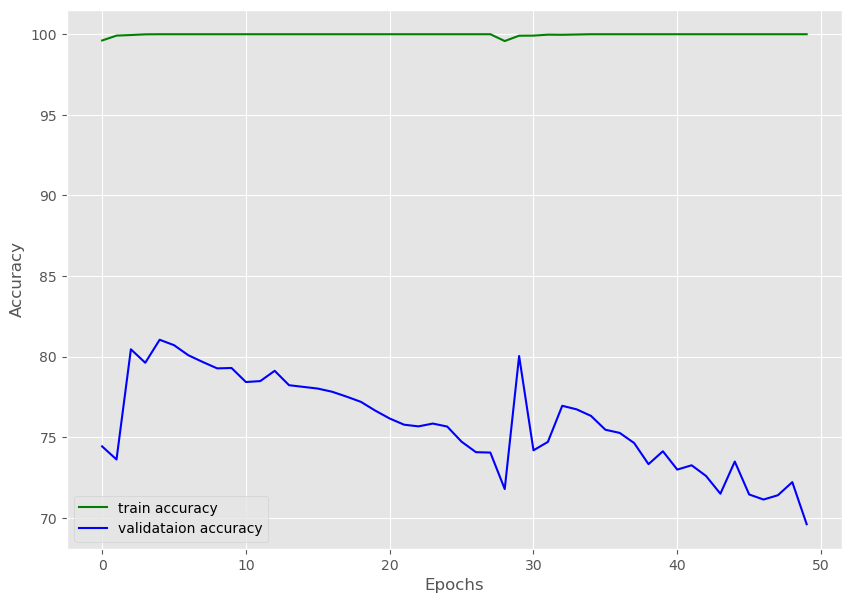

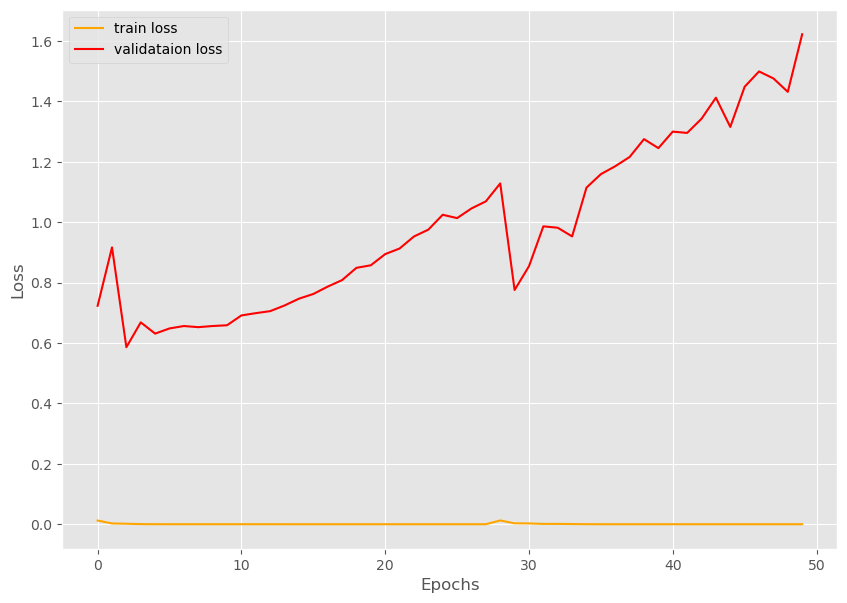

TRAINING COMPLETE


In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(PLOT_DIR, 'accuracy.png'))
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(PLOT_DIR, 'loss.png'))
plt.show()
 
print('TRAINING COMPLETE')